In [16]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles'
#directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 100

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data = torch.empty(0, total_size - segment_to_skip, 5)
y_data = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/{directory}'):
        data = pd.read_csv(f'{main_dir}/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'alpha', 'A/A0']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data = torch.cat((X_data, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data = torch.cat((y_data, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# save tensors to file
# swap last two dimensions
#X_data = X_data.permute(0, 2, 1)
#y_data = y_data.permute(0, 2, 1)
#torch.save(X_data, 'X_data_a0.pt')
#torch.save(y_data, 'y_data_a0.pt')

In [18]:
# load tensors from file
X_data = torch.load('X_data_a0.pt').to(torch.float64)
y_data = torch.load('y_data_a0.pt').to(torch.float64)

In [19]:
X_data.shape, y_data.shape

(torch.Size([12939, 5, 540]), torch.Size([12939, 3, 540]))

In [20]:
DX_UN  =   6.96000e+10  # length unit factor (to cm)
VX_UN  =   1.28557e+07  # speed unit factor (to cm/s)
TE_UN  =   1.00000e+06  # temperature unit factor (to K)
NE_UN  =   1.00000e+17  # density unit factor (to 1/cm^3)
DT_UN  =       5413.93  # time unit factor (to s)

NU_UN = (DX_UN**2)/DT_UN   # viscosity coeff init factor (to cm^2/s)

NU_VISC = .1 * NU_UN    # the actual viscosity coeff

In [21]:
rad = X_data[:, 0, :] * DX_UN  # xradial: radial coordinate in code units; rad: same in CGS
len_  = X_data[:, 1, :]  * DX_UN       # len, curvilinear coordinate in CGS
b_ = X_data[:, 2, :] # b: magnetic field in code units
alf = X_data[:, 3, :]          # inclin, alf: inclination angle alpha
aprimea = X_data[:, 4, :] / DX_UN # expans: A'/A in code units; aprimea: same in CGS (has dims of 1/L)


In [22]:
den = y_data[:, 0, :] * NE_UN       # n: density in code units; den: speed in CGS
vel = y_data[:, 1, :] * VX_UN       # u: speed in code units; vel: speed in CGS
tem = y_data[:, 2, :] * TE_UN  # t__mk_: temperature in code units (MK); tem temperature in CGS

In [26]:
# require grad on len_, den, vel, tem
len_.requires_grad = True
den.requires_grad = True
vel.requires_grad = True
tem.requires_grad = True

In [27]:
# create new X_data tensor by concatenating rad, len_, b_, alf, aprimea
X_data = torch.stack((rad, len_, b_, alf, aprimea), dim=1)
X_data.shape

torch.Size([12939, 5, 540])

In [28]:
y_data = torch.stack((den, vel, tem), dim=1)
y_data.shape

torch.Size([12939, 3, 540])

In [29]:
X_data.shape, y_data.shape

(torch.Size([12939, 5, 540]), torch.Size([12939, 3, 540]))

In [30]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9315, 5, 540]),
 torch.Size([2588, 5, 540]),
 torch.Size([9315, 3, 540]),
 torch.Size([2588, 3, 540]))

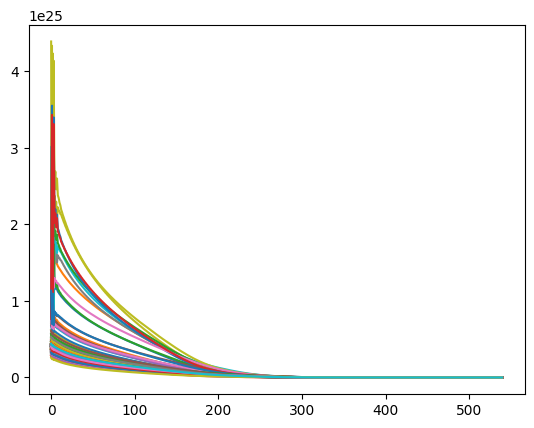

In [33]:
# plot the y_train first channel
import matplotlib.pyplot as plt
plt.plot(y_train[:200, 0, :].T.detach().numpy())
plt.show()

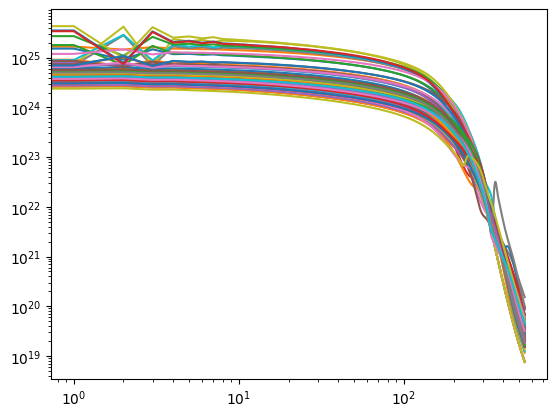

In [34]:
plt.loglog(y_train[:200, 0, :].T.detach().numpy())
plt.show()

In [35]:
# logscale the y_train and y_val first channel
y_train[:, 0, :] = torch.log(y_train[:, 0, :])
y_val[:, 0, :] = torch.log(y_val[:, 0, :])
y_test[:, 0, :] = torch.log(y_test[:, 0, :])

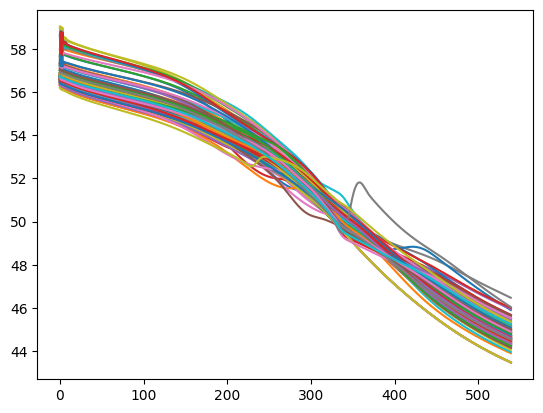

In [36]:
plt.plot(y_train[:200, 0, :].T.detach().numpy())
plt.show()

In [37]:
# normalize data according to the maximum and minimum value in each channel
# knowing that x_train has shape (len, channels, time)

# find max and min values for each channel
max_values_inputs = X_train.max(dim=2).values.max(dim=0).values
min_values_inputs = X_train.min(dim=2).values.min(dim=0).values

diff_inputs = max_values_inputs - min_values_inputs
# if diff is zero, then the channel is constant, so we should not normalize it
diff_inputs[diff_inputs == 0] = 1

# normalize
X_train_normalized = (X_train - min_values_inputs.unsqueeze(1)) / diff_inputs.unsqueeze(1)
X_val_normalized = (X_val - min_values_inputs.unsqueeze(1)) / diff_inputs.unsqueeze(1)
X_test_normalized = (X_test - min_values_inputs.unsqueeze(1)) / diff_inputs.unsqueeze(1)

max_values_inputs, min_values_inputs, diff_inputs

(tensor([2.1924966431e+12, 2.1924988998e+12, 4.8488305664e+03, 8.9257438660e+01,
         2.8417268319e-06], grad_fn=<MaxBackward0>),
 tensor([ 7.0379334068e+10,  7.0379607868e+10, -1.7187902832e+03,
         -8.7632102966e+01, -8.9016461252e-07], grad_fn=<MinBackward0>),
 tensor([2.1221173090e+12, 2.1221192920e+12, 6.5676208496e+03, 1.7688954163e+02,
         3.7318914444e-06], grad_fn=<IndexPutBackward0>))

In [38]:
# normalize y data
max_values_outputs = y_train.max(dim=2).values.max(dim=0).values
min_values_outputs = y_train.min(dim=2).values.min(dim=0).values

diff_outputs = max_values_outputs - min_values_outputs

diff_outputs[diff_outputs == 0] = 1

y_train_normalized = (y_train - min_values_outputs.unsqueeze(1)) / diff_outputs.unsqueeze(1)
y_val_normalized = (y_val - min_values_outputs.unsqueeze(1)) / diff_outputs.unsqueeze(1)
y_test_normalized = (y_test - min_values_outputs.unsqueeze(1)) / diff_outputs.unsqueeze(1)

max_values_outputs, min_values_outputs, diff_outputs

(tensor([6.0208101674e+01, 1.4547382693e+10, 4.9129590988e+06],
        grad_fn=<MaxBackward0>),
 tensor([ 4.2125982176e+01, -5.6577731289e+04,  5.7648890652e+03],
        grad_fn=<MinBackward0>),
 tensor([1.8082119498e+01, 1.4547439271e+10, 4.9071942098e+06],
        grad_fn=<IndexPutBackward0>))

In [39]:
import torch.nn as nn
import torch.optim as optim

# Model parameters
sequence_length = total_size - segment_to_skip
input_channels = 5
output_channels = 3
batch_size = 128

In [40]:
# create me a simple 1D convolutional network
class SimpleFeedForward(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleFeedForward, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_channels * sequence_length, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(2056, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(1024, 1024)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(1024, 2056)
        self.batchnorm4 = nn.BatchNorm1d(2056)
        self.dropout4 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(2056, output_channels * sequence_length)

        # Do xavier initialization
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        for layer in layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)

        x = self.dropout1(self.relu(self.batchnorm1(self.fc1(x))))
        x = self.dropout2(self.relu(self.batchnorm2(self.fc2(x))))
        x = self.dropout3(self.relu(self.batchnorm3(self.fc3(x))))
        x = self.dropout4(self.relu(self.batchnorm4(self.fc4(x))))
        x = self.fc5(x)

        x = x.reshape(batch_size, self.output_channels, sequence_length)

        return x


# Create an instance of the SimpleConvNet
model = SimpleFeedForward(input_channels, output_channels).to(device)

In [43]:
from torch.autograd import grad
class CustomCriterion(nn.Module):
    def __init__(self):
        super(CustomCriterion, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.lambda_ = 1e-8
        self.grav = 9.81
        
    def forward(self, inputs, preds, targets):
        smooth_l1_loss = self.smooth_l1_loss(preds, targets)
        
        R, L, alpha, aprimea = inputs[:, 0, :], inputs[:, 1, :], inputs[:, 3, :], inputs[:, 4, :]
        n, v, T = targets[:, 0, :], targets[:, 1, :], targets[:, 2, :]
        
        # n is distorted, need to rethink this
        
        # Compute gradients
        # Use sum() to convert tensors to scalar for grad computation
        derivative_nT_L = grad((n * T).sum(), L, create_graph=True, allow_unused=True)[0]
        derivative_v2_L = grad((v ** 2).sum(), L, create_graph=True, allow_unused=True)[0]
        derivative_v_L = grad(v.sum(), L, create_graph=True, allow_unused=True)[0]

        # Compute second-order derivative for v w.r.t R
        second_order_v_L = grad(derivative_v_L.sum(), L)[0]
        
        # ;; grad(pressure) term
        gradp  = derivative_nT_L / n

        # ;; gravitational term:
        gravf  = self.grav*torch.cos(alpha) / R**2

        #;; flow expansion term (v.grad)v, expanded into 4 sub-terms
        vgradva  = derivative_v2_L
        #vgradvb  = aprimea*vel^2
        vgradvc  = - v * derivative_v_L
        #vgradvd  = - aprimea*vel^2
        # ;;vgradv = vgradva + vgradvb + vgradvc + vgradvd
        # ;; terms B and Dcancel out:
        vgradv = vgradva + vgradvc 

        #;; viscous term (expanded in two terms)
        visca = second_order_v_L
        viscb = derivative_v_L*aprimea

        visc  = -NU_VISC*(visca+viscb)

        # ;; all together (should ~0)
        total_constraint = vgradv + gradp + gravf + visc
        
        return smooth_l1_loss + total_constraint

In [44]:
CustomCriterion()(X_train_normalized, y_train_normalized, y_train_normalized)

AttributeError: 'NoneType' object has no attribute 'sum'

In [ ]:
# create a training loop with early stopping and checkpointing withour using pytorch-lightning
from torch.utils.data import DataLoader, TensorDataset
from aim import Run

import numpy as np

# Initialize a new run
run = Run()

learning_rate = 0.01
scheduler_patience = 50
scheduler_factor = 0.5
scheduler_threshold = 1e-6

# Log run parameters
run["hparams"] = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "sequence_length": sequence_length,
    "scheduler_patience": scheduler_patience,
    "scheduler_factor": scheduler_factor,
    "scheduler_threshold": scheduler_threshold,
    "loss": "SmoothL1 + ConstantVectorPenalty"
}

# create a dataset and a dataloader
train_dataset = TensorDataset(X_train_normalized, y_train_normalized)
val_dataset = TensorDataset(X_val_normalized, y_val_normalized)
test_dataset = TensorDataset(X_test_normalized, y_test_normalized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# create criterion with smooth l1 loss
criterion = CustomCriterion()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# add reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True, threshold=scheduler_threshold)

In [21]:
# training loop
n_epochs = 10000
patience = 500
min_loss = np.inf
counter = 0
best_model = None

for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    model.train()
    train_loss = 0
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(x, y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    run.track({'loss': train_loss}, context={'subset': 'train'}, epoch=epoch)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            y_pred = model(x)
            loss = criterion(x, y_pred, y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        run.track({'loss': val_loss}, context={'subset': 'validation'}, epoch=epoch)
    
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    scheduler.step(train_loss)

Epoch 0Epoch 1Epoch 2Epoch 3Epoch 4Epoch 5Epoch 6Epoch 7Epoch 8Epoch 9Epoch 10Epoch 11Epoch 12Epoch 13Epoch 14Epoch 15Epoch 16Epoch 17Epoch 18Epoch 19Epoch 20Epoch 21Epoch 22Epoch 23Epoch 24Epoch 25Epoch 26Epoch 27Epoch 28Epoch 29Epoch 30Epoch 31Epoch 32Epoch 33Epoch 34Epoch 35Epoch 36Epoch 37Epoch 38Epoch 39Epoch 40Epoch 41Epoch 42Epoch 43Epoch 44Epoch 45Epoch 46Epoch 47Epoch 48Epoch 49Epoch 50Epoch 51Epoch 52

: 

In [24]:
# save the best model
torch.save(best_model, 'best_model_pinn_fnn_540.pth')

In [81]:
# load the best model
model = SimpleFeedForward(input_channels, output_channels)
model.load_state_dict(torch.load('best_model_pinn_fnn_540.pth', map_location=device))

<All keys matched successfully>

In [82]:
X_test_normalized.shape

torch.Size([2588, 4, 540])

In [99]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt

lim = 50

y_pred = model(X_test_normalized[:lim, :, :])

# denormalize
y_pred = y_pred * diff_outputs.unsqueeze(1) + min_values_outputs.unsqueeze(1)

# revert logscale on first channel
y_pred[:, 0, :] = torch.exp(y_pred[:, 0, :])

y_pred = y_pred.detach().numpy()

y_test_ = y_test[:lim, :, :]

y_test_[:, 0, :] = torch.exp(y_test_[:, 0, :])

y_test_ = y_test_.detach().numpy()


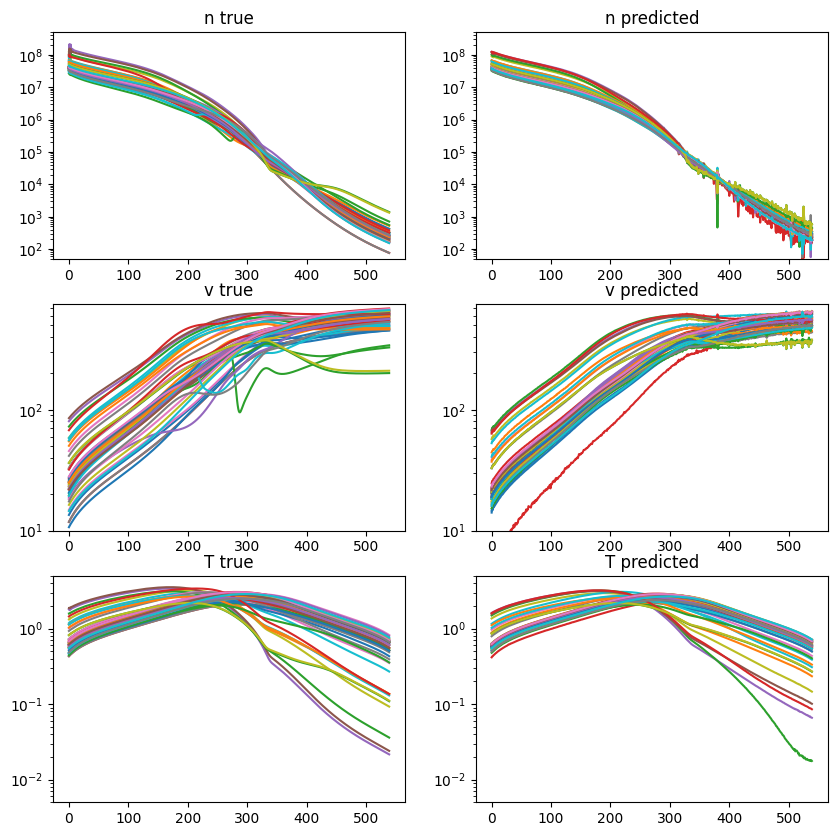

In [101]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [10, 750], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test_[:, i, :].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, :].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


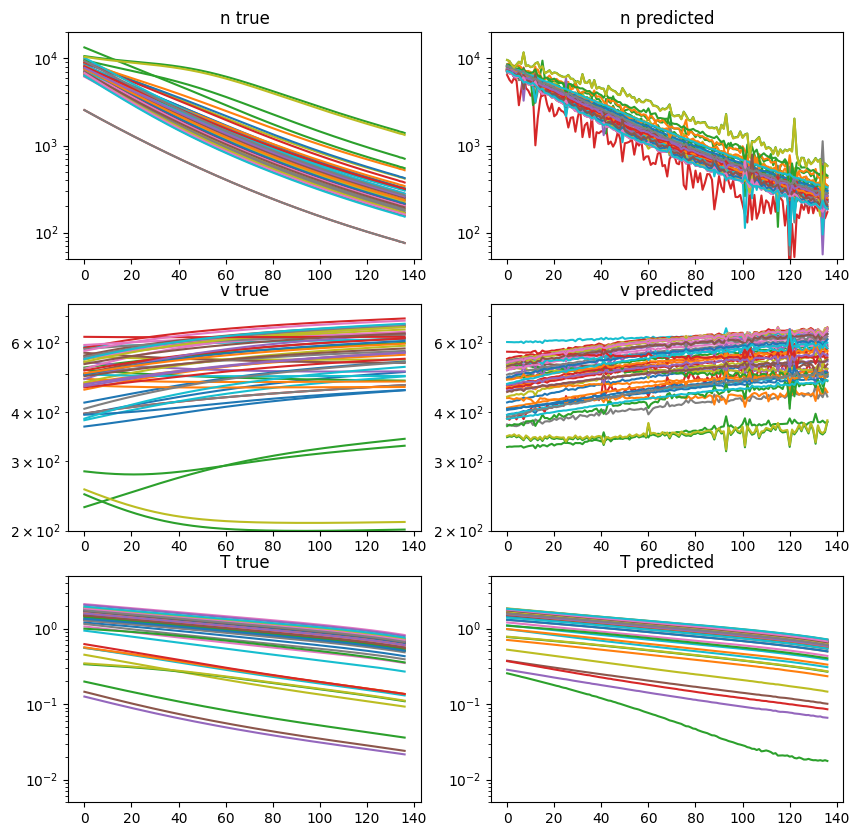

In [104]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 20000], [200, 750], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test_[:, i, 403:].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, 403:].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


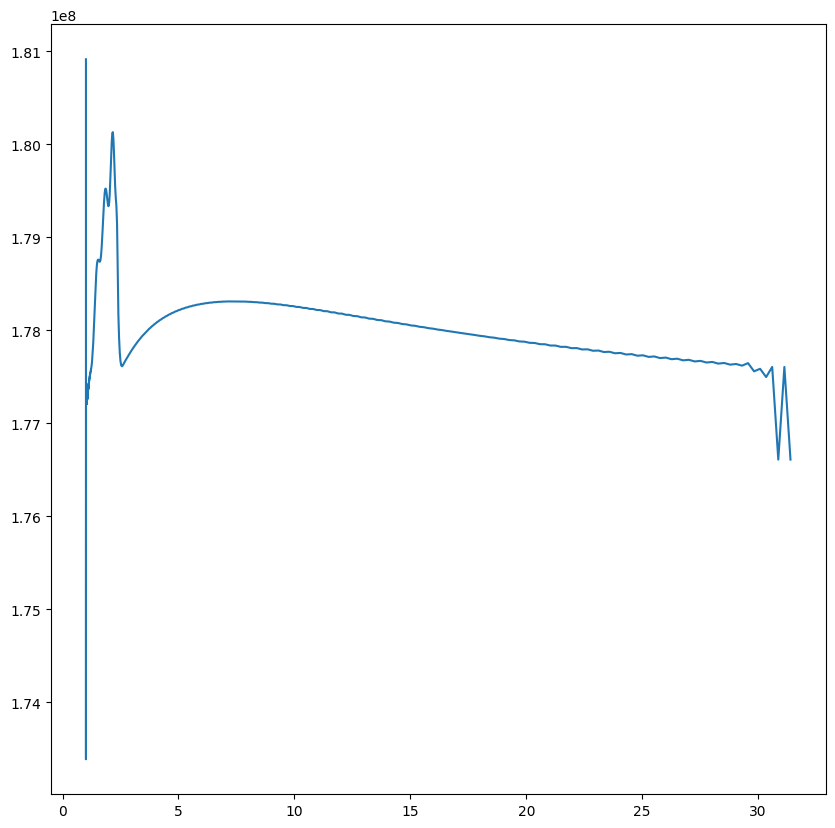

In [69]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test_normalized[:lim, 2, :] * diff_inputs[2] + min_values_inputs[2]
nvB = (y_test[:lim, 0, :] * y_test[:lim, 1, :]) / B_unnormalized

r_unnormalized = X_test_normalized[:lim, 0, :] * diff_inputs[0] + min_values_inputs[0]

plt.plot(r_unnormalized[0, :].T, nvB[0, :].T)
plt.show()

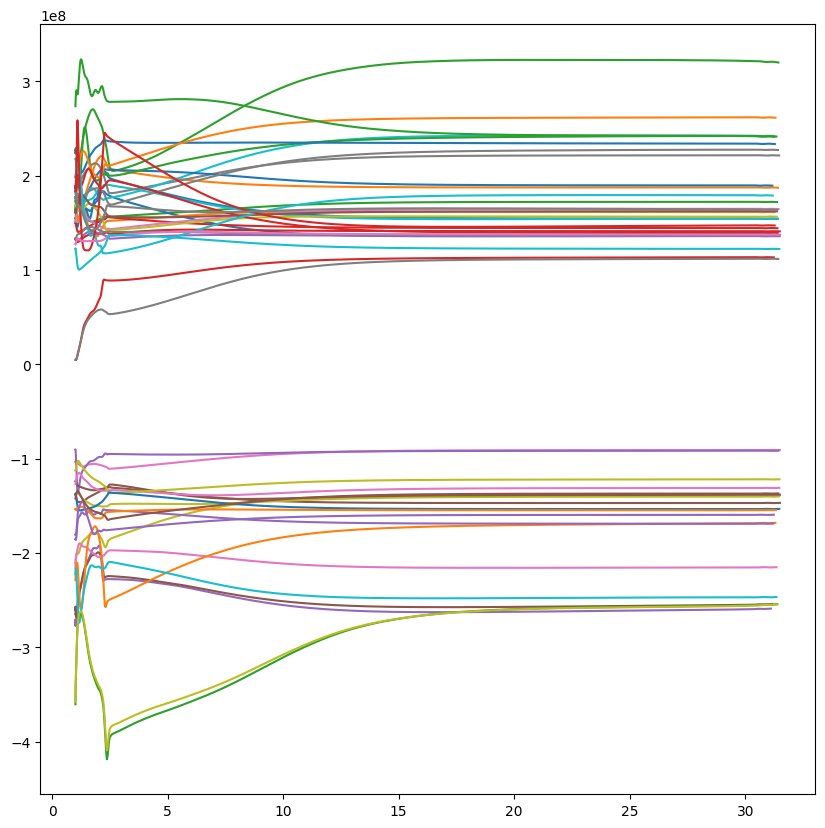

In [65]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test_normalized[:lim, 2, :] * diff_inputs[2] + min_values_inputs[2]
nvB = (y_pred[:, 0, :] * y_pred[:, 1, :]) / B_unnormalized

r_unnormalized = X_test_normalized[:lim, 0, :] * diff_inputs[0] + min_values_inputs[0]

plt.plot(r_unnormalized.T, nvB.T)
plt.show()

In [31]:
# loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y_pred = model(x)
        # denormalize y_pred and y
        loss = criterion(x, y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss}')

Test loss: 0.036201712985571344


3 hidden layers

48 nodes

ReLU

dropout 0.2 em todas